In [97]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns
sns.set_style("dark")

from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as EM

# Dim reduction
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from scipy.stats import kurtosis 

# Models
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_digits
from utils import learning_curve_plotter, model_param_curve, metrics

In [2]:
seed = 777

In [3]:
# Diabet Load Dataset

diabet_path = "./data/diabetes.csv"
df_diabet = pd.read_csv(diabet_path)

target = 'Outcome'
features = [ 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

X_origin, y = df_diabet[features], df_diabet[target]

# data normalize
sc = MinMaxScaler()
sc.fit(X_origin)

X = sc.transform(X_origin)
X_df = pd.DataFrame(X)
df_diabet = pd.concat([X_df, y], axis=1)

In [52]:
# Load Dataset

mnist = load_digits()

# fig, axes = plt.subplots(2, 10, figsize=(16, 6))
# for i in range(20):
#     axes[i//10, i %10].imshow(mnist.images[i], cmap='gray');
#     axes[i//10, i %10].axis('off')
#     axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")
    
# plt.tight_layout()

# data normalize
# sc = MinMaxScaler()
# sc.fit(mnist.data)

# X = sc.transform(mnist.data)
X_df = pd.DataFrame(X)
y_target = pd.DataFrame(mnist.target)
df_digit = pd.concat([X_df, y_target], axis=1)

# Clustering

## K-means Clustering

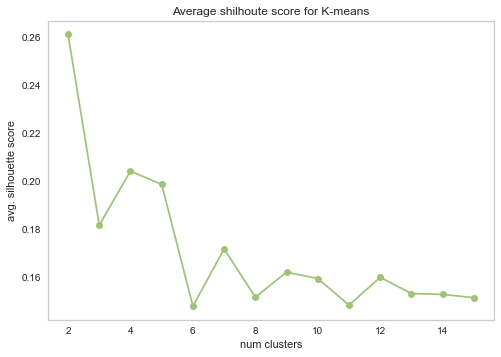

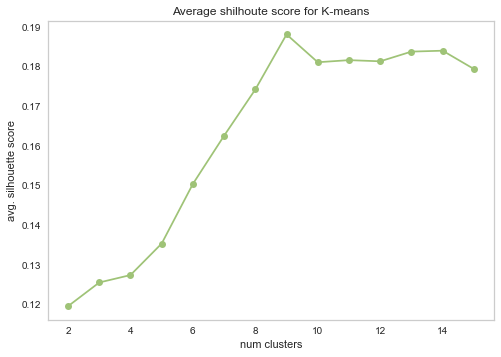

In [5]:
"""
https://m.blog.naver.com/slykid/221850725829
https://nicola-ml.tistory.com/6

shilhoutte analysis
각 군집 간의 거리가 얼마나 효율적으로 분리되어 있는지
-1~1사이의 값을 가지며 1에 가까울수록 좋다.
값이 높으면 객체가 자체 클러스터와 잘 일치, 클러스터와 잘 일치하지 않음.
"""

num_k = 15

def kmeans(df, num_k=15):
    sil_scores = []
    for k in range(2, num_k+1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=seed).fit(df.iloc[:,:-1])
        sil_score = silhouette_score(df.iloc[:,:-1], kmeans.labels_)
        sil_scores.append(sil_score)
    
    return sil_scores

def silhouette_plotter(sil_scores, num_k, title_name=None):
    plt.title(title_name)
    plt.xlabel("num clusters")
    plt.ylabel("avg. silhouette score")
    plt.grid()
    plt.plot(list(range(2, num_k+1)), sil_scores, "-o", color="C1")
    plt.show()
    plt.close()

diabet_sil_scores = kmeans(df_diabet)
digit_sil_scores = kmeans(df_digit)

silhouette_plotter(diabet_sil_scores, num_k, title_name="Average shilhoute score for K-means")
silhouette_plotter(digit_sil_scores, num_k, title_name="Average shilhoute score for K-means")

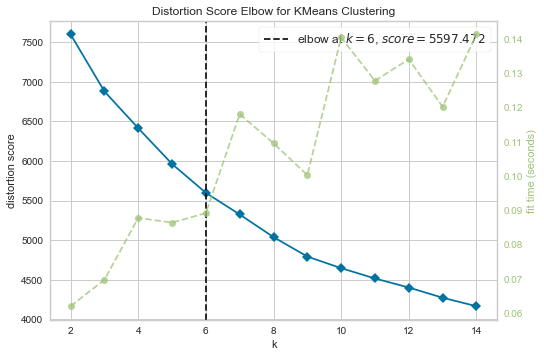

In [6]:
# 결과는 다음과 같이 나왔는데, 파란색이 각 데이터들의 군집 중심과의 평균 거리
# 초록색은 학습 시간을 나타낸다고 합니다.
# 검정색 점선의 위치를 보았을 떄, 여기서는 k = 4인 경우를 추천해주는 듯 합니다.
# 절대적인 정답이 있는 것은 아니니, 하나의 평가 지표로 활용하시면 좋을 듯 합니다.

def elbow_plotter(df_x, num_k):
    kmeans = KMeans()
    visualizer = KElbowVisualizer(kmeans, k=(2,num_k))
    visualizer.fit(df_x)
    visualizer.show()
    
# elbow_plotter(df_diabet.iloc[:,:-1], num_k)
elbow_plotter(df_digit.iloc[:,:-1], num_k)

In [7]:
def knn_clustering_scores(optimal_k, df):
    kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=seed).fit(df.iloc[:,:-1])
    prediction = kmeans.predict(df.iloc[:,:-1])
    cluster_df = pd.DataFrame()
    cluster_df["kmeans_cluster"] = prediction
    cluster_df["target"] = df.iloc[:,-1]
    cluster_result = cluster_df.groupby(["target"])["kmeans_cluster"].value_counts()
    return cluster_df, cluster_result

digit_cluster, digit_result = knn_clustering_scores(10, df_digit)
diabet_cluster, diabet_result = knn_clustering_scores(2, df_diabet)

In [8]:
digit_result

target  kmeans_cluster
0       0                 177
        9                   1
1       6                  99
        7                  55
        4                  24
        3                   2
        5                   1
        8                   1
2       4                 148
        5                  13
        6                   8
        1                   3
        2                   2
        7                   2
        0                   1
3       5                 157
        2                  10
        6                   7
        1                   6
        8                   2
        4                   1
4       9                 164
        1                   7
        7                   6
        6                   4
5       8                 136
        2                  41
        5                   2
        9                   2
        3                   1
6       3                 177
        6                   2
        0        

In [9]:
# pca = PCA(random_state=seed, n_components=dim)
# X_pca = pca.fit_transform(df_digit.iloc[:,:-1])

# # pca.explained_variance_ratio_

# X_pca = pd.DataFrame(X_pca, columns=["x", "y"])
# target = pd.DataFrame(df_digit.iloc[:,-1]).reset_index(drop=True)
# merged = pd.concat([X_pca, target], axis=1)

# # markers=['^', 's', 'o']

# # plt.figure(figsize=(16, 9))
# # plt.grid()

# # markers=['s', 'o']
# # for i, marker in enumerate(markers):
# #     x_axis_data = merged[merged['0']==i]['x']
# #     y_axis_data = merged[merged['0']==i]['y']
# #     plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=30)

# # plt.legend()
# # plt.show()

# nn_clf = MLPClassifier(random_state=seed, max_iter=1000, early_stopping=False, activation="tanh")
# scores = cross_val_score(nn_clf, X_pca, df_digit.iloc[:,-1], scoring="accuracy", cv=3)
# print(np.mean(scores))

## EM algorithm

- 가우시안 분포: 도수 분포 곡선이 평균값을 중심으로 좌우 대칭
- GMM (Gaussian Mixture Model): 군집화에 대한 데이터가 여러개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정
- GMM에서 모수추정을 위해 2가지 추정방법: 개별 정규 분포의 평균과 분산 / 각 데이터가 어떤 정규 분포에 해당하는지의 확률

In [10]:
def em(df, num_k=15):
    sil_scores, aic_scores, bic_scores = [], [], []
    
    for k in range(2, num_k+1):        
        em = EM(n_components=k, warm_start=True, random_state=seed).fit(df.iloc[:,:-1])
        pred = em.predict(df.iloc[:,:-1])
        sil_score = silhouette_score(df.iloc[:,:-1], pred)
        sil_scores.append(sil_score)
        aic_scores.append(em.aic(df.iloc[:,:-1]))
        bic_scores.append(em.bic(df.iloc[:,:-1]))
        
    return sil_scores, aic_scores, bic_scores

def plotter(scores, num_k, title_name=None, color=None):
    plt.title(title_name)
    plt.xlabel("num clusters")
    plt.ylabel("avg. silhouette score")
    plt.grid()
    plt.plot(list(range(2, num_k+1)), scores, "-o", color=color)
    plt.show()
    plt.close()

def em_clustering_scores(optimal_k, df):
    em = EM(n_components=optimal_k, n_init=10, random_state=seed).fit(df.iloc[:,:-1])
    prediction = em.predict(df.iloc[:,:-1])
    cluster_df = pd.DataFrame()
    cluster_df["em_cluster"] = prediction
    cluster_df["target"] = df.iloc[:,-1]
    cluster_result = cluster_df.groupby(["target"])["em_cluster"].value_counts()
    return cluster_df, cluster_result


diabet_scores = em(df_diabet)
digit_scores = em(df_digit)

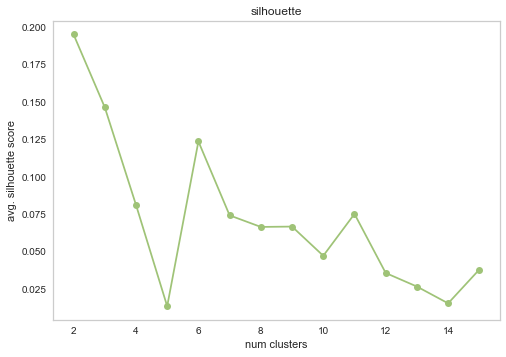

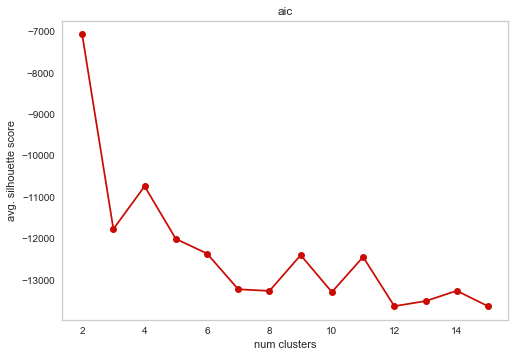

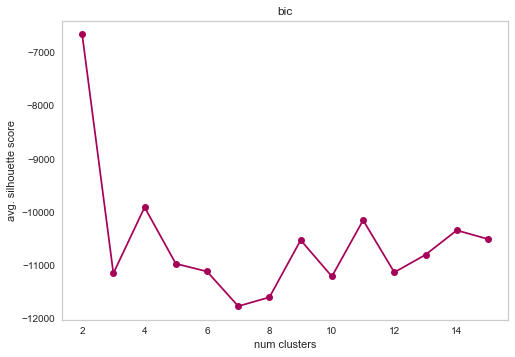

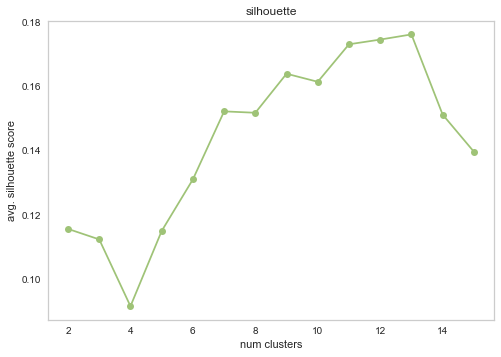

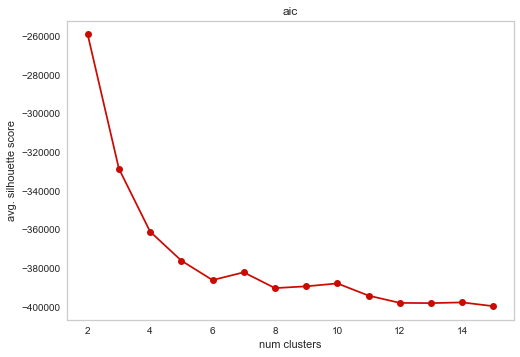

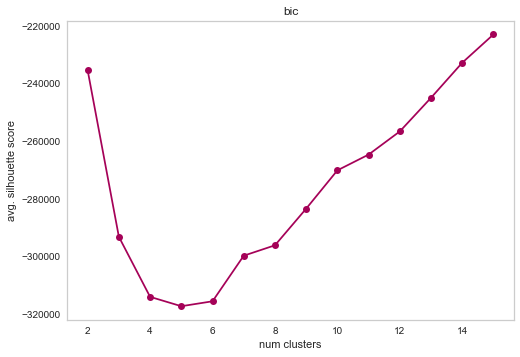

In [11]:
# Plotting
plotter(diabet_scores[0], num_k, title_name="silhouette", color="C1")
plotter(diabet_scores[1], num_k, title_name="aic", color="C2")
plotter(diabet_scores[2], num_k, title_name="bic", color="C3")

plotter(digit_scores[0], num_k, title_name="silhouette", color="C1")
plotter(digit_scores[1], num_k, title_name="aic", color="C2")
plotter(digit_scores[2], num_k, title_name="bic", color="C3")

In [12]:
digit_cluster, digit_result = em_clustering_scores(10, df_digit)
# diabet_cluster, diabet_result = em_clustering_scores(2, df_diabet)

In [17]:
sil_scores = []
aic_scores = []
bic_scores = []

for k in range(2, num_k+1):
    em = EM(n_components=k, warm_start=True, random_state=seed).fit(df_diabet.iloc[:,:-1])
    pred = em.predict(df_diabet.iloc[:,:-1])
    sil_score = silhouette_score(df_diabet.iloc[:,:-1], pred)
    sil_scores.append(sil_score)
    aic_scores.append(em.aic(df_diabet.iloc[:,:-1]))
    bic_scores.append(em.bic(df_diabet.iloc[:,:-1]))
    
#     return sil_score, aic_scores, bic_scores

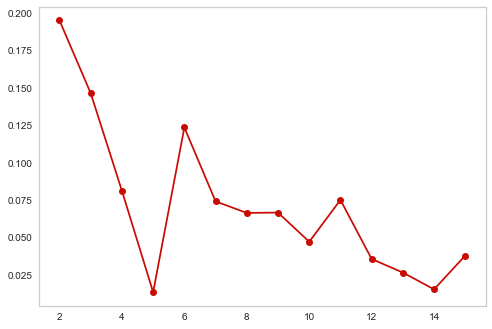

In [19]:
plt.plot(list(range(2, num_k+1)), sil_scores, "-o", color="C2")
# plt.plot(list(range(2, num_k+1)), aic_scores, "-o", color="C5")
# plt.plot(list(range(2, num_k+1)), bic_scores, "-o", color="C7")
plt.grid()
plt.show()

In [ ]:
digit_cluster

# Dimensionality Reduction

In [ ]:
# df_diabet, df_digit

In [ ]:
# Clustering 시각화 → DR 진행 → DR + Clustering → DR + NN (Assign #1) → DR + Clustering + NN
# https://wjddyd66.github.io/handson/Ch8.Dimensionality_Reduction/

dim = 2

def mlp_classifer(df, hidden_size=30, lr=0.1, max_iter=1000):
    # best parameter tester
    nn_clf = MLPClassifier(
        random_state=seed,
        hidden_layer_sizes=hidden_size,
        learning_rate_init=lr,
        max_iter=max_iter
    )
    
    nn_clf.fit(df.iloc[:,:-1], df.iloc[:,-1])
    
    return nn_clf

mlp_classifer(df_digit)
mlp_classifer(df_diabet)

## PCA

In [104]:
def kurtosis_val(df):
    return kurtosis(df.iloc[:,-1])

print(f"diabet: {kurtosis_val(df_diabet)}")
print(f"digit: {kurtosis_val(df_digit)}")

diabet: -1.5983283582089547
digit: -1.2147296065623656


8


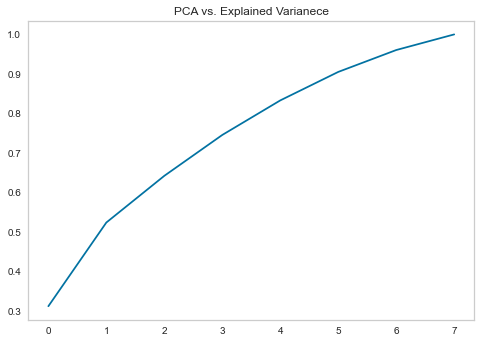

In [59]:
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# print(cumsum)
# d = np.argmax(cumsum >= 0.95) + 1
# print(d)

def pca_explained_var(df):

    print(len(df.columns)-1)
    
    pca = PCA(random_state=seed, n_components=(len(df.columns)-1)).fit(df.iloc[:,:-1])
    plt.grid()
    plt.title("PCA vs. Explained Varianece")
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
#     plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
#     plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))


# pca_explained_var(df_diabet)
# pca_explained_var(df_digit)

In [133]:
def plot_func(df, dim=2, mode="None"):
    
    if mode == "pca":
        pca = PCA(random_state=seed, n_components=dim)
        X_feature = pca.fit_transform(df.iloc[:,:-1])
    elif mode == "ica":
        ica = FastICA(random_state=seed, n_components=dim)
        X_feature = ica.fit_transform(df.iloc[:,:-1])
    elif mode == "rp":
        rp = SparseRandomProjection(random_state=seed, n_components=dim)
        X_feature = rp.fit_transform(df.iloc[:,:-1])
        
    y = df.iloc[:,-1]
    
    plt.figure(figsize=(25, 16))
    plt.grid()
    plt.title(mode)
    
    plt.scatter(X_feature[:,0], X_feature[:,1], c=y, alpha=0.5, s=50)
    
#     for i in range(0, dim):
#         for j in range(0, dim):
#             if i == j:
#                 continue
#             plt.scatter(X_feature[:,i], X_feature[:,j], alpha=0.5, s=20)
    
    plt.show()
    plt.close()

#     X_pca = pd.DataFrame(X_pca, columns=["x", "y"])
#     target = pd.DataFrame(df.iloc[:,-1]).reset_index(drop=True)
#     merged = pd.concat([X_pca, target], axis=1)

#     colors = ['b','g','r','c','m','y','k','w']
#     markers=['s', 'o']
#     for i, marker in enumerate(markers):
#         print(i)
        
#         x_axis_data = merged[merged['Outcome']==i]["x"]
#         y_axis_data = merged[merged['Outcome']==i]["y"]
#         plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=30)    

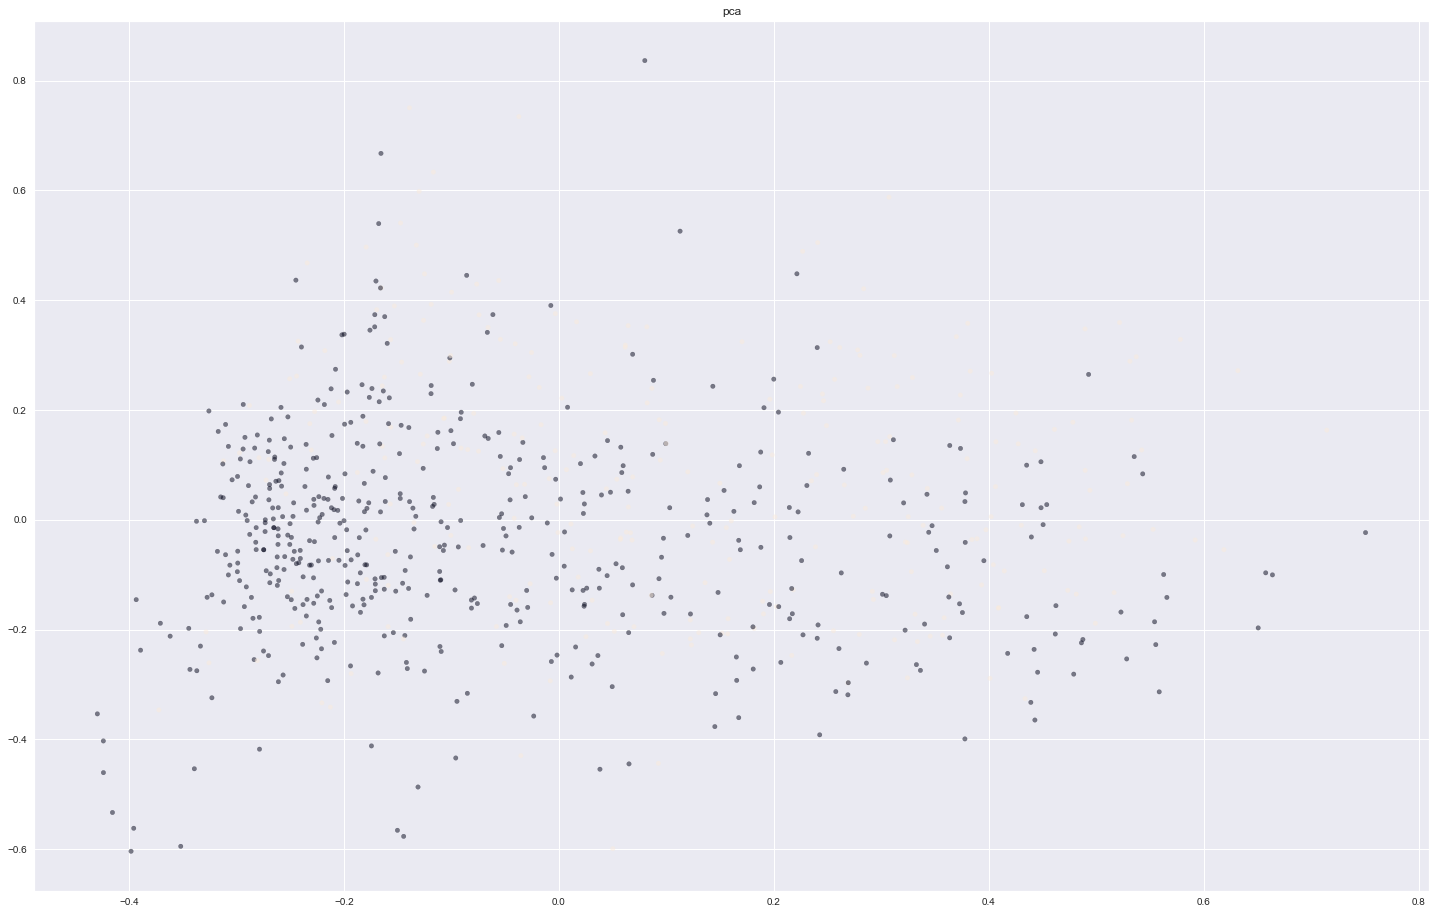

In [129]:
# plot_func(df_diabet, dim=2, mode="pca")
# # plot_func(df_digit, dim=2, mode="pca")

# plot_func(df_diabet, dim=2, mode="ica")
# # plot_func(df_digit, dim=2, mode="ica")

# plot_func(df_diabet, dim=2, mode="rp")
# plot_func(df_digit, dim=2, mode="rp")

In [135]:
def calc_score_func(df, dim=2, mode="None", cv=3):

    nn_clf = MLPClassifier(random_state=seed, max_iter=1000, early_stopping=False, activation="tanh")
    
    if mode == "mlp":
        X_feature = df.iloc[:,:-1]
    elif mode == "pca":
        pca = PCA(random_state=seed, n_components=dim)
        X_feature = pca.fit_transform(df.iloc[:,:-1])
    elif mode == "ica":
        ica = FastICA(random_state=seed, n_components=dim).fit(df.iloc[:,:-1])
        X_feature = ica.fit_transform(df.iloc[:,:-1])
    elif mode == "rp":
        rp = SparseRandomProjection(random_state=seed, n_components=dim)
        X_feature = rp.fit_transform(df.iloc[:,:-1])

    scores = cross_val_score(nn_clf, X_feature, df.iloc[:,-1], scoring="accuracy", cv=cv).mean()
    
    return scores

In [136]:
# mlp_diabet_score = calc_score_func(df_diabet, mode="mlp")
# mlp_digit_score = calc_score_func(df_digit, mode="mlp")
# print(mlp_diabet_score)
# print(mlp_digit_score)

# pca_diabet_score = calc_score_func(df_diabet, mode="pca")
# pca_digit_score = calc_score_func(df_digit, mode="pca")
# print(pca_diabet_score)
# print(pca_digit_score)

# ica_diabet_score = calc_score_func(df_diabet, mode="ica")
# ica_digit_score = calc_score_func(df_digit, mode="ica")
# print(ica_diabet_score)
# print(ica_digit_score)

rp_diabet_score = calc_score_func(df_diabet, mode="rp")
rp_digit_score = calc_score_func(df_digit, mode="rp")
print(rp_diabet_score)
print(rp_digit_score)

0.6822916666666666
0.3444629938786867


## ICA

In [82]:
# # ica = FastICA(random_state=seed, n_components=2)
# # X_ica = ica.fit_transform(df_digit.iloc[:,:-1])
# # # X_ica = pd.DataFrame(X_ica, columns=["x", "y"])
# # # target = pd.DataFrame(df_diabet.iloc[:,-1]).reset_index(drop=True)
# # # merged = pd.concat([X_ica, target], axis=1)

# plt.figure(figsize=(16, 9))
# plt.grid()

# markers=['s', 'o']
# for i, marker in enumerate(markers):
#     x_axis_data = merged[merged['Outcome']==i]['x']
#     y_axis_data = merged[merged['Outcome']==i]['y']
#     plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=30)

# plt.legend()
# plt.show()

# scores_pca = cross_val_score(nn_clf, X_ica, df_diabet.iloc[:,-1], scoring="accuracy", cv=3)
# print(np.mean(scores_pca))

## Randomized Projections

In [ ]:
rp = SparseRandomProjection(random_state=seed, n_components=dim)
X_rp = rp.fit_transform(df_diabet.iloc[:,:-1])
X_rp = pd.DataFrame(X_rp, columns=["x", "y"])
target = pd.DataFrame(df_diabet.iloc[:,-1]).reset_index(drop=True)
merged = pd.concat([X_rp, target], axis=1)

In [ ]:
plt.figure(figsize=(16, 9))
plt.grid()

markers=['s', 'o']
for i, marker in enumerate(markers):
    x_axis_data = merged[merged['Outcome']==i]['x']
    y_axis_data = merged[merged['Outcome']==i]['y']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=20)

plt.legend()
plt.show()

In [ ]:
scores_rp = cross_val_score(nn_clf, X_rp, df_diabet.iloc[:,-1], scoring="accuracy", cv=3)
print(np.mean(scores_rp))

# Truncated SVD

In [ ]:
svd = TruncatedSVD(n_components=2, random_state=seed)
# X_svd = svd.fit(df_diabet.iloc[:,:-1])
X_svd = svd.fit_transform(df_diabet.iloc[:,:-1])
X_svd = pd.DataFrame(X_svd, columns=["x", "y"])

merged = pd.concat([X_svd, target], axis=1)

# target = pd.DataFrame(df_diabet.iloc[:,-1]).reset_index(drop=True)
# merged = pd.concat([X_lda, target], axis=1)

plt.figure(figsize=(16, 9))
plt.grid()

markers=['s', 'o']
for i, marker in enumerate(markers):
    x_axis_data = merged[merged['Outcome']==i]['x']
    y_axis_data = merged[merged['Outcome']==i]['y']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i, s=20)

plt.legend()
plt.show()

In [ ]:
scores_svd = cross_val_score(nn_clf, X_svd, df_diabet.iloc[:,-1], scoring="accuracy", cv=3)
print(np.mean(scores_lda))

In [ ]:
# https://github.com/srpatel625/cs7641-assignment3